In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve


from xgboost import XGBClassifier

In [2]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')

%matplotlib inline
linewidth = 3

In [4]:
X_train, y_train = np.load('./X_train.npy'), np.load('./y_train.npy')
X_test, y_test = np.load('./X_test.npy'), np.load('./y_test.npy')

In [5]:
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))

In [6]:
X.shape

(67226, 3)

In [7]:
xgb_model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, eval_metric='mlogloss', use_label_encoder=False)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [8]:
param_grid = {
    "max_depth": [3, 8, 10], 
    "n_estimators": [50, 100]
}

In [9]:
CV_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=kfold)

In [10]:
CV_xgb.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=0, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_ch...ight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                

In [11]:
best_params = CV_xgb.best_params_

In [12]:
CV_xgb.best_score_

0.8100054266491064

In [13]:
CV_xgb.best_params_

{'max_depth': 10, 'n_estimators': 50}

In [15]:
random_state = np.random.RandomState(0)

cv = StratifiedKFold(n_splits=10, shuffle=True)
classifier  = XGBClassifier(n_estimators = best_params['n_estimators'], 
                            max_depth = best_params['max_depth'],
                            tree_method='gpu_hist', 
                            gpu_id=0,
                            random_state=random_state, eval_metric='mlogloss', use_label_encoder=False)

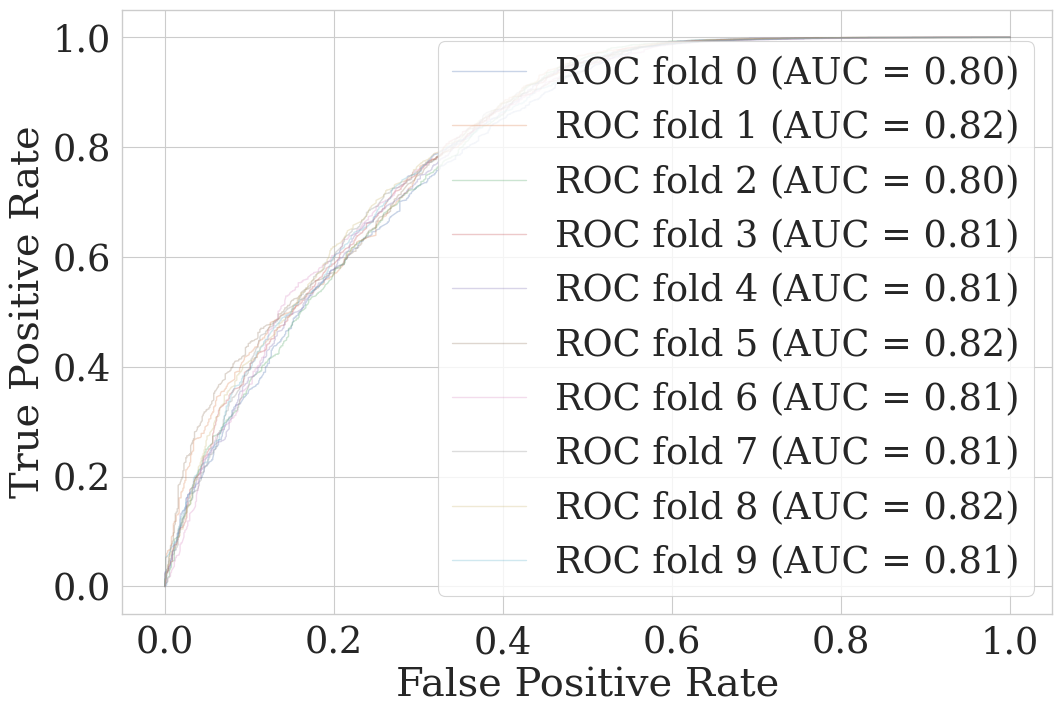

In [16]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

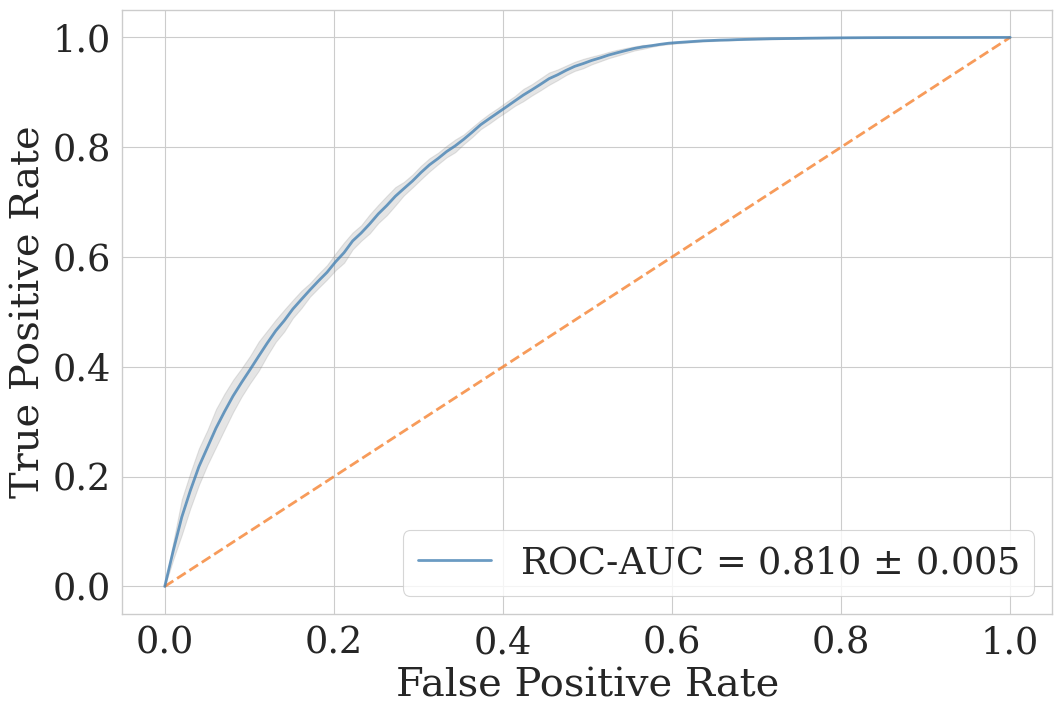

In [17]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='#f58231', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='steelblue',
        label=r'ROC-AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="")
ax.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
fig.savefig("rocauc.pdf", bbox_inches='tight')
plt.show()

In [18]:
from numpy import interp

def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    """
    Draw a Cross Validated PR Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series

    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    y_real = []
    y_proba = []


    precision_array = []
    threshold_array=[]
    recall_array = np.linspace(0, 1, 100)

    i = 0
    
    fig = plt.figure(figsize=(12, 8), dpi=100)
    pr_aucs = []
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        precision, recall, thresh = precision_recall_curve(y[test], probas_[:, 1])
        
        precision_fold, recall_fold, thresh = precision[::-1], recall[::-1], thresh[::-1]  # reverse order of results
        thresh = np.insert(thresh, 0, 1.0)
        precision_array = interp(recall_array, recall_fold, precision_fold)
        threshold_array = interp(recall_array, recall_fold, thresh)

        # Plotting each individual PR Curve
        #plt.plot(recall, precision, lw=1, alpha=0.3,
        #         label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y[test], probas_[:, 1])))

        y_real.append(y[test])
        y_proba.append(probas_[:, 1])
        pr_aucs.append(average_precision_score(y[test], probas_[:, 1]))
        i += 1

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)

    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    print(pr_aucs)
    plt.plot(recall, precision, color='steelblue',
             label=r'PR-AUC = %0.3f $\pm$ %0.3f' % (np.mean(pr_aucs), np.std(pr_aucs)),
             lw=2, alpha=.8)
    
    mean_precision = np.mean(precision_array)
    std_precision = np.std(precision_array)
    precision_upper = np.minimum(precision + std_precision, 1)
    precision_lower = np.maximum(precision - std_precision, 0)
    plt.fill_between(recall, precision_upper, precision_lower, alpha=0.3, linewidth=0, color='grey')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig("pr_rec.pdf", bbox_inches='tight')

[0.9592426637308957, 0.9544278745121897, 0.9512319034188181, 0.9565318259382335, 0.9559602934962601, 0.959031155254398, 0.9587754384276046, 0.9597152768928126, 0.9523678234758999, 0.9598658301427417]


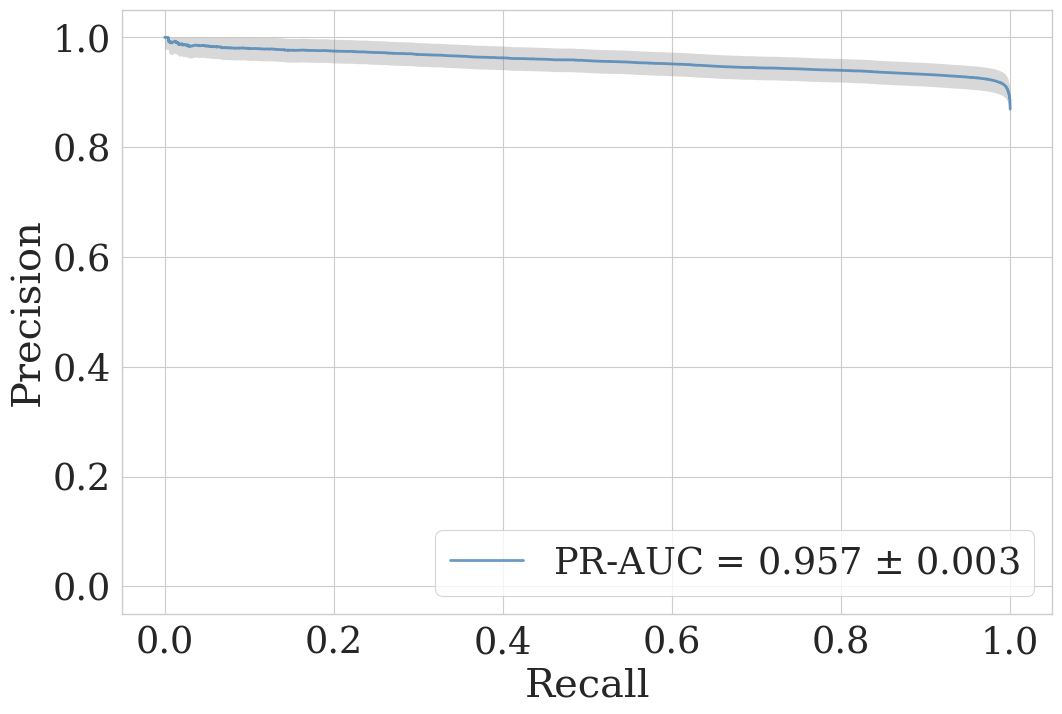

In [19]:
draw_cv_pr_curve(classifier, cv, X, y, title='')